# **Modelo de prediccion de padecimiento de un stroke**
(ACCIDENTE CARDIO VASCULAR - ACV)

### **Resumen Teorico**

#### **Objetivo**
Predecir la probabilidad de que un paciente sufra un stroke **(ACV)** a partir de variables demográficas, clínicas y de estilo de vida.


#### **Tipo de Modelado**
- Tipo de problema: Clasificación binaria (stroke: 0 o 1)
- Modelos a aplicar:
  - 3 modelos tradicionales:
    - Logistic Regression
    - Random Forest
    - Support Vector Machine (SVM)
  - Red Neuronal con 1 capa oculta
  - Red Neuronal con múltiples capas ocultas (DNN)


#### **Procesamiento y Preparación del Dataset**
<table>
  <thead>
    <th>Columna</th>
    <th>Tipo</th>
    <th>Tratamiento</th>
  </thead>
  <tbody>
    <tr>
      <td>id</td>
      <td>Identificador</td>
      <td>Eliminar (no aporta valor predictivo)</td>
    </tr>
    <tr>
      <td>gender</td>
      <td>Categórica</td>
      <td>One-hot encoding o Label encoding</td>
    </tr>
    <tr>
      <td>age</td>
      <td>Numérica</td>
      <td>Normalizar o escalar</td>
    </tr>
    <tr>
      <td>hypertension</td>
      <td>Binaria (0/1)</td>
      <td>Usar directamente</td>
    </tr>
    <tr>
      <td>heart_disease</td>
      <td>Binaria (0/1)</td>
      <td>Usar directamente</td>
    </tr>
    <tr>
      <td>ever_married</td>
      <td>Categórica</td>
      <td>Convertir a 0 (No), 1 (Yes)</td>
    </tr>
    <tr>
      <td>work_type</td>
      <td>Categórica</td>
      <td>One-hot encoding</td>
    </tr>
    <tr>
      <td>Residence_type</td>
      <td>Categórica</td>
      <td>One-hot encoding (Urban/Rural)</td>
    </tr>
    <tr>
      <td>avg_glucose_level</td>
      <td>Numérica</td>
      <td>Normalizar o escalar</tr>
    <tr>
      <td>bmi</td>
      <td>Numérica</td>
      <td>Imputar valores nulos (media o regresión)</td>
    </tr>
    <tr>
      <td>smoking_status</td>
      <td>Categórica</td>
      <td>One-hot encoding, considerar categoría 'unknown'</td>
    <tr>
      <td>stroke</td>
      <td>Binaria</td>
      <td>Variable objetivo</td>
    </tr>
  </tbody>
</table>

#### **Pipeline sugerido (EDA y Modelado)**
**EDA (Exploratory Data Analysis)**
- Distribución del target (stroke) → Notarás que está desbalanceado.
- Distribuciones por age, bmi, glucose_level.
- Gráficas por categoría (work_type vs stroke, gender vs stroke).
- Heatmap de correlaciones.
- Outliers (en bmi, glucose, etc).

**Preprocesamiento**
- Encoding de variables categóricas.
- Escalado de variables numéricas.
- Imputación de valores nulos (bmi).
- Balanceo de clases con SMOTE o class_weight.

**Modelos Tradicionales**
- Logistic Regression (baseline simple, interpretable).
- Random Forest (para ver importancia de variables).
- SVM (bueno para espacios de alta dimensión).

Evalúa con:
- accuracy, precision, recall, f1-score, AUC
- Confusion matrix
- Curva ROC



### **Preparando Ambiente**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### **Importando Dataset**

In [6]:
df = pd.read_csv("sample_data/healthcare-dataset-stroke-data.csv")


In [7]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [8]:
df.head(10)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


### **Preparando Dataset**
Preparación completa del dataset que emplearemos en modelos de Machine Learning, en un problema de clasificación binaria (detectar si una persona ha tenido un acv o no)

In [9]:
# Eliminar columna 'id'
df.drop('id', axis=1, inplace=True)

# Ver nulos
print(df.isnull().sum())

# Imputar BMI con media
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

# Codificar variables categóricas
df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1})
df = pd.get_dummies(df, columns=['gender', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)

# Separar X e y
X = df.drop('stroke', axis=1)
y = df['stroke']

# Balancear clases con SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Dividir dataset
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Escalar variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


/tmp/ipython-input-2127421218.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)


### **Preparando Modelos de Entrenamiento**
Evalúamos tres modelos de clasificación: Logistic Regression, Random Forest, y SVM, utilizando classification_report para mostrar métricas como precisión, recall, F1-score y accuracy.

In [10]:
#Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
#Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred_rf))
#SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM")
print(classification_report(y_test, y_pred_svm))


Logistic Regression
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       975
           1       0.87      0.87      0.87       970

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945

Random Forest
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       975
           1       0.97      0.96      0.96       970

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945

SVM
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       975
           1       0.89      0.91      0.90       970

    accuracy                           0.90      1945
   macro avg       0.90      0.90      0.90      1945
weighted avg       0.90      0.90   

#### **Preparando Redes Neuronales**

##### **1 Capa**

In [11]:
model1 = Sequential()
model1.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
model1.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Evaluar
loss, acc, auc = model1.evaluate(X_test, y_test)
print(f"NN (1 capa) - Accuracy: {acc:.4f}, AUC: {auc:.4f}")


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6648 - auc: 0.7738 - loss: 0.5830
Epoch 2/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8511 - auc: 0.9285 - loss: 0.3696
Epoch 3/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8713 - auc: 0.9442 - loss: 0.3088
Epoch 4/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8771 - auc: 0.9510 - loss: 0.2862
Epoch 5/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8746 - auc: 0.9484 - loss: 0.2910
Epoch 6/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8886 - auc: 0.9533 - loss: 0.2771
Epoch 7/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8826 - auc: 0.9528 - loss: 0.2775
Epoch 8/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8866 - auc: 0.9592 - loss: 0.2583
Epoch 9/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8890 - auc: 0.9584 - loss: 0.2612
Epoch 10/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8887 - auc: 0.9614 - loss: 0.2525
Epoch 11/3

##### **Multiples Capas**

In [12]:
model2 = Sequential()
model2.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
model2.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Evaluar
loss, acc, auc = model2.evaluate(X_test, y_test)
print(f"NN (múltiples capas) - Accuracy: {acc:.4f}, AUC: {auc:.4f}")


Epoch 1/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7724 - auc_1: 0.8622 - loss: 0.4751
Epoch 2/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8862 - auc_1: 0.9557 - loss: 0.2687
Epoch 3/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8958 - auc_1: 0.9650 - loss: 0.2398
Epoch 4/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8994 - auc_1: 0.9678 - loss: 0.2307
Epoch 5/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8959 - auc_1: 0.9642 - loss: 0.2415
Epoch 6/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9132 - auc_1: 0.9726 - loss: 0.2113
Epoch 7/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9166 - auc_1: 0.9750 - loss: 0.2009
Epoch 8/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9276 - auc_1: 0.9774 - loss: 0.1925
Epoch 9/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9092 - auc_1: 0.9743 - loss: 0.2126
Epoch 10/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9272 - auc_1: 0

#### **Comparacion de Modelos**
- Crea un diccionario, donde almacenaremos las predicciones de tres modelos diferentes: Logistic Regression, Random Forest, y SVM.

- Calcularemos la matriz de confusion para cada modelo y mostraremos los resultados de las metricas de clasificacion

In [13]:
models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "SVM": y_pred_svm
}

for name, preds in models.items():
    print(f"\n{name}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))



Logistic Regression
[[852 123]
 [124 846]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       975
           1       0.87      0.87      0.87       970

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945


Random Forest
[[942  33]
 [ 40 930]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       975
           1       0.97      0.96      0.96       970

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945


SVM
[[870 105]
 [ 91 879]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       975
           1       0.89      0.91      0.90       970

    accuracy                           0.90      1945
   macro avg      

#### **Validacion de Modelo**
Evaluacion de matriz de confusion de cada modelo

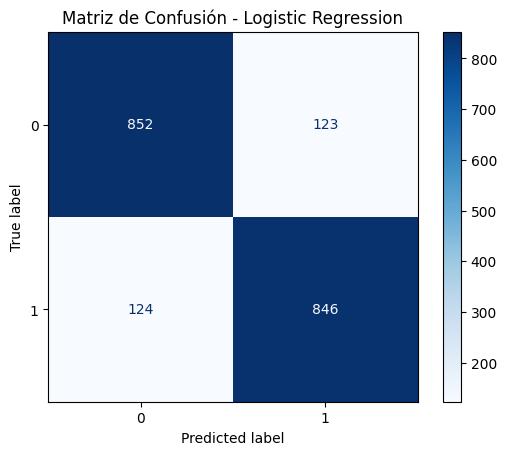

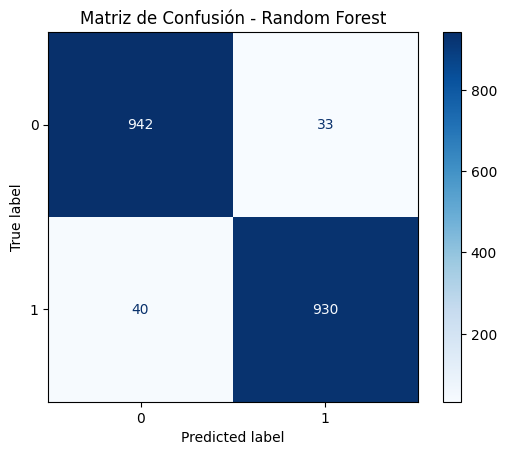

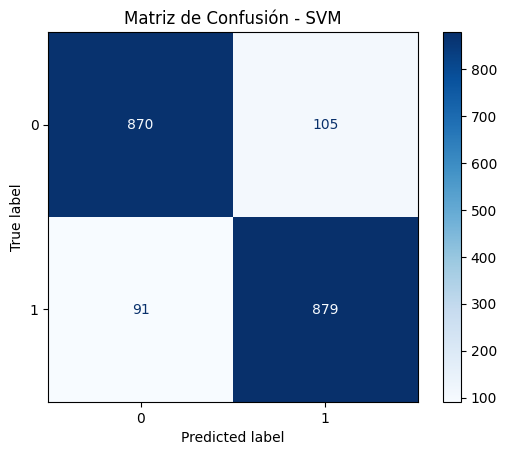

In [14]:
# Para cada modelo clásico
model_preds = {
    'Logistic Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'SVM': y_pred_svm
}

for name, preds in model_preds.items():
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()


Informe detallado de cada uno de los modelos.

In [15]:
for name, preds in model_preds.items():
    print(f"--- {name} ---")
    print(classification_report(y_test, preds))


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       975
           1       0.87      0.87      0.87       970

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       975
           1       0.97      0.96      0.96       970

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945

--- SVM ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       975
           1       0.89      0.91      0.90       970

    accuracy                           0.90      1945
   macro avg       0.90      0.90      0.90      1945
weighted avg

##### **Evaluacion de Probabilidad**
Obtención de las probabilidades de las predicciones de cada modelo, tanto de los modelos clásicos (Logistic Regression, Random Forest, SVM) como de las Redes Neuronales.

In [16]:
# Clásicos
y_probs_lr = lr.predict_proba(X_test)[:,1]
y_probs_rf = rf.predict_proba(X_test)[:,1]
y_probs_svm = svm.predict_proba(X_test)[:,1]

# Redes Neuronales
y_probs_nn1 = model1.predict(X_test).ravel()
y_probs_nn2 = model2.predict(X_test).ravel()


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


##### **ROC**
Graficar las curvas ROC (Receiver Operating Characteristic) de los diferentes modelos para evaluar el rendimiento de los modelos de clasificación binaria a través de diferentes umbrales de decisión.

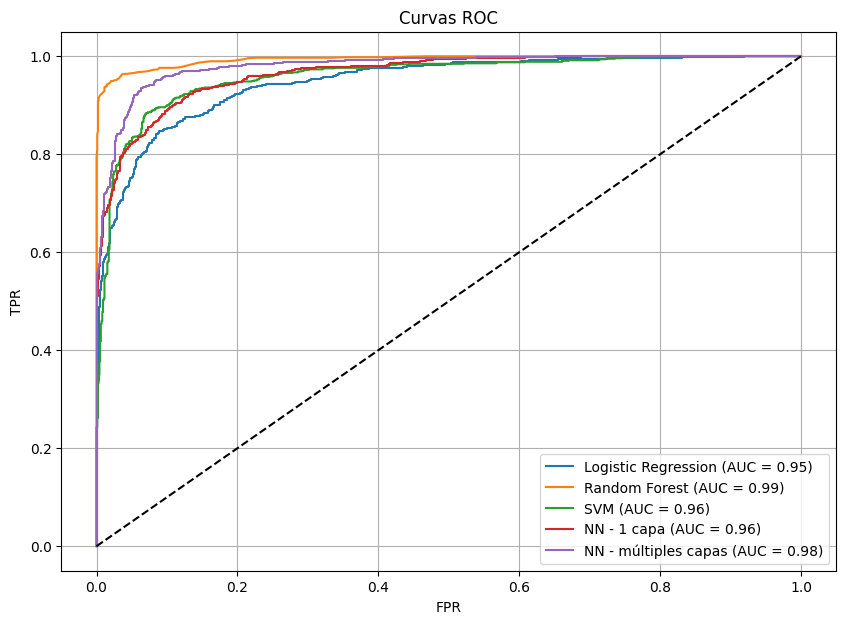

In [19]:
plt.figure(figsize=(10, 7))

# Función para plot ROC
def plot_roc(y_test, y_probs, label):
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plot_roc(y_test, y_probs_lr, 'Logistic Regression')
plot_roc(y_test, y_probs_rf, 'Random Forest')
plot_roc(y_test, y_probs_svm, 'SVM')
plot_roc(y_test, y_probs_nn1, 'NN - 1 capa')
plot_roc(y_test, y_probs_nn2, 'NN - múltiples capas')

plt.plot([0,1], [0,1], 'k--')
plt.title('Curvas ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True)
plt.show()


##### **Evaluacion de Rendimientos**
Evaluar y comparar el rendimiento de los diferentes modelos que has entrenado (Logistic Regression, Random Forest, SVM, y las redes neuronales) utilizando las predicciones y probabilidades obtenidas en el conjunto de test

In [22]:
# Calcular todas las métricas
def get_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob)
    }

# Generar diccionario
metrics = {
    'Logistic Regression': get_metrics(y_test, y_pred_lr, y_probs_lr),
    'Random Forest': get_metrics(y_test, y_pred_rf, y_probs_rf),
    'SVM': get_metrics(y_test, y_pred_svm, y_probs_svm),
    'NN - 1 capa': get_metrics(y_test, (y_probs_nn1 > 0.5).astype(int), y_probs_nn1),
    'NN - múltiples capas': get_metrics(y_test, (y_probs_nn2 > 0.5).astype(int), y_probs_nn2),
}

# Convertir a DataFrame
df_metrics = pd.DataFrame(metrics).T
df_metrics = df_metrics.round(4)
print(df_metrics)


                      Accuracy  Precision  Recall  F1-Score     AUC
Logistic Regression     0.8730     0.8731  0.8722    0.8726  0.9469
Random Forest           0.9625     0.9657  0.9588    0.9622  0.9935
SVM                     0.8992     0.8933  0.9062    0.8997  0.9590
NN - 1 capa             0.8931     0.9002  0.8835    0.8918  0.9639
NN - múltiples capas    0.9260     0.8964  0.9629    0.9284  0.9796
